In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import cv2
import time 
import xlrd       # pip install xlrd
import xlsxwriter # pip install xlscwriter

In [2]:
### Basic operations ###



def hilight(img,Morph=True,Plot=False):
    img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)     # Convert from BGR to RGB
    Th = 240
    R,G,B = img[:,:,0],img[:,:,1],img[:,:,2]        # Separate img into RGB
    MR =   1*(R >= Th)                              # Red Mask
    MG =   1*(G >= Th)                              # Green Mask
    MB =   1*(B >= Th)                              # Blue Mask

    M = (MR * MG * MB).astype(np.uint8)              # Get total mask
    
    ### Apply Morphological operations ###
    kernel = np.ones((1,1),np.uint8)                 # Initialize kernel
    if Morph:
        M = cv2.morphologyEx(M, cv2.MORPH_OPEN, kernel)  # Apply Openning 
        M = cv2.morphologyEx(M, cv2.MORPH_CLOSE, kernel) # Apply Closing 
    img2 = np.copy(img)                              # Copy image so we can modify it
    
    img2[:,:,0] = img[:,:,0]*M                       # Multiply Red   Channel por total Mask
    img2[:,:,1] = img[:,:,1]*M                       # Multiply Green Channel por total Mask
    img2[:,:,2] = img[:,:,2]*M                       # Multiply Blue  Channel por total Mask
 
    if Plot:
        plot_operation(img2,new,title)
        
    new = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)  # Convert from BGR to RGB
    return new 

def dynamic_treshold(frame,offset,lower):
    S = frame.shape
    N = S[0]
    M = S[1]
    Maximo = -1
    for n in range(0,N):
        for m in range(0,M):
            v = frame[n,m] 
            if v > Maximo:
                Maximo = frame[n,m]
    
    if Maximo < lower:
        th = lower
        print(th)
      
    else:
        th =  Maximo - offset
        print(th)

    return th


def hilight_gray(img,Th,Morph=True,Plot = False):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    
    
    M =   1*(img >= Th)                         # Red Mask
    M = M.astype(np.uint8)                      # Get Mask as unsigned intiger 
    
    ### Apply Morphological operations ###
    kernel1 = np.ones((5,5),np.uint8)                 # Initialize kernel
    kernel2 = np.ones((7,7),np.uint8)                 # Initialize kernel
    if Morph:
        M = cv2.morphologyEx(M, cv2.MORPH_OPEN, kernel1)  # Apply Openning 
        M = cv2.morphologyEx(M, cv2.MORPH_CLOSE, kernel2) # Apply Closing 
      
    img2 = img*M                                     # Multiply Red   Channel por total Mask
    
    if Plot:
        plt.imshow(img2)
    return  img2


In [3]:
def angle_between_vectors(v1,v2):
    v1_norm = np.linalg.norm(v1)           # compute norm of vector 1
    v2_norm = np.linalg.norm(v2)           # Compute norm of vector 2
    intern = v1.dot(v2)/(v1_norm*v2_norm)  # Divide dot product over mulitplication of norms
    angle = np.arccos(intern)              # Find angle with definition of dot product
    angle = angle*(180/np.pi)              # Convert radians to degrees
    return angle 
    

def find_centroids(cnts):
    """ Finds centroids of countours:
        cnts = Countours
        How it works: we use  10 and 00 Hue moments, we know the 00 moment is the area of the image
        
    """
    """ Finds centroids"""
    CX   = []                               # List to store x coordinates of centroids                         
    CXo  = []                               # List to store x coordinates of centroids in order (from Max area to min area)  
    CY   = []                               # List to store y coordinates of centroids
    CYo  = []                               # List to store y coordinates of centroids in order (from Max area to min area)  
    Area = []                               # List to store Area of contours found 
    for c in cnts:
    ### compute the center of the contour ##
        M = cv2.moments(c)                  # Compute Hue moments
        cX = int(M["m10"] /( M["m00"]))     # Get cX by definition
        cY = int(M["m01"] / (M["m00"]))     # Get cY by definition
        CX.append(cX)                       # Append x component of centroid
        CY.append(cY)                       # Append y component of centroid
        Area.append(M["m00"])               # Append area of blob
    idx = order_3_max(Area)                 # Obtain index order (from bigest to smallest)
    for i in idx:                           # Iterate over idx
        CXo.append(CX[i])                   # append centroids in order (x component)
        CYo.append(CY[i])                   # append centroids in order (y component)
        
    return CXo,CYo
  
def find_centroids(cnts):
    """ Finds centroids of countours:
        cnts = Countours
        How it works: we use  10 and 00 Hue moments, we know the 00 moment is the area of the image
        
    """
    """ Finds centroids"""
    CX   = []                               # List to store x coordinates of centroids                         
    CY   = []                               # List to store y coordinates of centroids
    for c in cnts:
    ### compute the center of the contour ##
        M = cv2.moments(c)                  # Compute Hue moments
        cX = int(M["m10"] /( M["m00"]))     # Get cX by definition
        cY = int(M["m01"] / (M["m00"]))     # Get cY by definition
        CX.append(cX)                       # Append x component of centroid
        CY.append(cY)                       # Append y component of centroid
        
    return CX,CY
        


def digital_goniomertry(video_path,th,scale_percent=80,version= "sticky",line="conitnues"):
    global frame
    global positionx
    global width
    global height
    global positiony
    angles = []
    positionx = []
    positiony = []
    capture = cv2.VideoCapture(video_path)  # load video
    kernel = np.ones((6,6),np.uint8)        # Kernel for Openning  
    
    ### stethic stuff ###
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (20,40)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
    #####################
    
    status = True                           # Variable to iterate over frames
    initialization = True 
    CXM = np.array([0,0,0])
    CYM = np.array([0,0,0])
    while status:                           # While loop 
        status,frame = capture.read()       # Reads video, returns (status,frame)
        if status == True:                  # If there is a frame
            width = int(frame.shape[1] * scale_percent / 100)
            height = int(frame.shape[0] * scale_percent / 100)
            dim = (width, height)
            frame =  cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
            new = hilight_gray(frame,th)
            new = new.astype(np.uint8)
            cv2.normalize(frame, frame, 0, 255, cv2.NORM_MINMAX)
            contours, hierarchy = cv2.findContours(new,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Get contours
            try:
                CX,CY = find_centroids(contours)
            
                angle = round(get_angle(CX,CY),2)
                if version == "sticky":
                    frame = frame*0 + 255
                    fontColor = (0,0,0)
                    
                elif version == "normal":
                    pass

                ### Draw centroids ###                 #B    G   R
                cv2.circle(frame , (CX[0], CY[0]), 6, (233, 101, 0), -1)
                ######### Compute center of mass  ######
                CMassX = int((CX[1] + CX[0])/2)
                CMassY = int(CY[1]+CY[0]*0.4)
                positionx.append(CMassX)
                positiony.append(CMassY)
                ########################################
                cv2.circle(frame , (CMassX,CMassY), 9, (0, 233, 255), -1)   # Centro de masa
                cv2.circle(frame , (CX[1], CY[1]), 6, (89, 71, 255), -1)
                cv2.circle(frame , (CX[2], CY[2]), 6, (20, 157, 15), -1)
                
               
                ### Draw lines
                cv2.line(frame, (CX[0], CY[0]),(CX[1], CY[1]), (219, 236, 50), 4) 
                cv2.line(frame, (CX[0], CY[0]),(CX[2], CY[2]), (219, 236, 50), 4) 
                
                angles.append(angle)
                if initialization:               # This part of code only runs during intialization (First Frame)
                    CXM = CX                     # first element of list of X cordiantes is the first centroid recorded
                    CYM = CY                     # first element of list of Y cordiantes is the first centroid recorded
                    initialization = False       # Set initalization to False, this will never run agian
                    
                elif  initialization == False:   # This part of the code runs if initializon was done correctly
                    CX = np.array(CX)            # Create a numpy.array from python list 
                    CY = np.array(CY)            # Create a numpy.array from python list 
                    CXM = np.vstack((CXM,CX))    # Stack horizontally the values of centroids
                    CYM = np.vstack((CYM,CY))    # Stack horizontally the values of centroids
                    
                    ### Draw line of movment of center of mass ###
                    if line == "conitnues":
                        cv2.line(frame, (positionx[0], positiony[0]),(positionx[-1], positiony[-1]), (0, 233, 255), 1) 
                    elif line == "discrete":
                        for px,py in zip(positionx,positiony):                 # iterate over points collected
                            cv2.circle(frame , (px, py), 2, (0, 233, 255), -1) # Draw all of them in current frame

                #print(CX,CY)

                
                ### Draw text ###
                cv2.putText(frame,str(angle), bottomLeftCornerOfText,font, fontScale,fontColor,lineType)
                cv2.imshow("Video",frame)
                
              
            except:
                pass
                                         # Display it on Window


        if cv2.waitKey(1) & 0xFF == ord('q'): # If q is pressed 
            break                             # Break from while loop

    cv2.destroyAllWindows()                   # Destroy window
    capture.release()                         # Release video (free memory)
    
    ############# Compute movement of center of mass in X and Y axis #########
    Dx = 180         # The camara recorded an area that has 180 cm of distance
    Dy = 120         # The camare recorded an area that has 120 cm of heigth
    CFX = Dx/width   # Convertion from pixel to cm for x axis
    CFY = Dy/height  # Convertion from pixel to cm for y axis
    Xmovement = (np.max(positionx) - np.min(positionx))*CFX            # Get range of x axis
    Ymovement = (np.max(positiony) - np.min(positiony))*CFY            # Get range of y axis
    
    
    ### Print summarys ###
    
    print(f"Movement  of center of mass in X: {round(Xmovement,2)} cm , Movement in Y: {round(Ymovement,2)} cm")
    MAX = np.max(angless)
    MIN = np.min(angless)
    print(f"ROM {MIN} - {MAX}")

    return angles,CXM,CYM,

In [4]:
def color_mask(frame,th,color):
    """ BGR """
    #### Select appropiate chanel for color selection ###
    if color == "blue":
        c =  0
    elif color == "green":
        c = 1
    elif color == "red":
        c =  2
    
    Mask = 1*(frame[:,:,c] >= th).astype(np.uint8)  # Create mask (only selects pixles that are greater than threshold)
    return Mask,c


In [5]:
def digital_goniomertry(video_path,th,scale_percent=80,version= "sticky",line="conitnues"):
    global frame
    global positionx
    global width
    global height
    global positiony
    angles_r = []
    angles_c = []
    angles_t = []
    positionx = []
    positiony = []
    capture = cv2.VideoCapture(video_path)  # load video
    ### stethic stuff ###
    font                   =  0
    bottomLeftCornerOfText = (20,20)
    bottomLeftCornerOfText2= (20,40)
    bottomLeftCornerOfText3= (20,60)
    fontScale              = 0.4
    fontColor              = (255,255,255)
    lineType               = 1
    #####################
    status = True                           # Variable to iterate over frames
    initialization = True 
    CXM = np.array([0,0,0])
    CYM = np.array([0,0,0])
    while status:                           # While loop 
        status,frame = capture.read()       # Reads video, returns (status,frame)
        if status == True:                  # If there is a frame
            if initialization:
                ### Obtain shapes in order to do scaling ###
                width = int(frame.shape[1]*scale_percent / 100)
                height = int(frame.shape[0]*scale_percent / 100)        
                dim = (width, height)
                
            frame =  cv2.resize(frame, dim, interpolation = cv2.INTER_AREA) # Rescale video
            
            ### Obtain frames by channel (BGR) ###
            M_cadera,rc  =  color_mask(frame,th,color="red")     # Obtain Mask for Cadera (Red channel)
            M_rodilla,bc =  color_mask(frame,th,color="blue")    # Obtain Mask for Rodilla (Blue channel)
            M_tobillo,gc =  color_mask(frame,th,color="green")   # Obtain Mask for tobillo (Green Channel)
            cadera  =  M_cadera*frame[:,:,rc]                    # Obtain frame for cadera
            rodilla =  M_rodilla*frame[:,:,bc]                   # Obtain frame for rodilla
            tobillo =  M_tobillo*frame[:,:,gc]                   # Obtain frame for tobillo
            
            ### Obtian the countrors of every image ###
            contours_c, hierarchy = cv2.findContours(cadera,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Get contours
            contours_r, hierarchy = cv2.findContours(rodilla,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Get contours
            contours_t, hierarchy = cv2.findContours(tobillo,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Get contours
            contours=  [contours_c[0],contours_r[0],contours_t[0]]
            
            ### Obtian Centroids ###
            CX,CY = find_centroids(contours)
            Centroids_cadera  = np.array([CX[0],CY[0]])                    # From image
            Centroids_ref_cadera = np.array([CX[0],CY[0]-20])  
            Centroids_rodilla = np.array([CX[1],CY[1]])                    # From image
            Centroids_ref_rodilla = np.array([CX[2] ,CY[1]-12])  
            Centroids_tobillo = np.array([CX[2],CY[2]])                    # From image
            ### Obtain cetnroids using anatomic truth ###
            
            Centroids_masa =    np.array([CX[0],int(CY[0] - .50*CY[0])])   # Created from data
            Centroids_feet =    np.array([CX[2],int(CY[2] + .040*CY[2])])   # Created from data 
            
            if version == "sticky":
                frame = frame*0 + 255
                fontColor = (0,0,0)
                    
            elif version == "normal":
                pass

            
            ### Draw centroids ###                                               #B    G   R
            cv2.circle(frame , (Centroids_cadera[0],  Centroids_cadera[1]),  3, (0,   0, 255), -1) # Cadera
            cv2.circle(frame , (Centroids_rodilla[0], Centroids_rodilla[1]), 3, (255, 0,   0), -1) # Rodilla
            cv2.circle(frame , (Centroids_tobillo[0], Centroids_tobillo[1]), 3, (0,  255,  0), -1) # tobillo
            
            ### Mass ceneter (sagital plane) ###
            cv2.circle(frame , (Centroids_masa[0],  Centroids_masa[1]),  4, (255,   0, 255), -1)         # Centro de masa
            cv2.circle(frame , (Centroids_feet[0], Centroids_feet[1]), 3,fontColor, -1)
            
            
            ### Draw lines ###
            cv2.line(frame,(Centroids_masa[0], Centroids_masa[1]),(Centroids_cadera[0], Centroids_cadera[1]),fontColor, 1) 
            cv2.line(frame,(Centroids_cadera[0], Centroids_cadera[1]),(Centroids_rodilla[0], Centroids_rodilla[1]), fontColor, 1)
            #### Linea parlalela
            cv2.line(frame,(Centroids_cadera[0], Centroids_cadera[1]),(Centroids_ref_cadera[0],Centroids_ref_cadera[1]), fontColor, 1)
            cv2.line(frame,(Centroids_rodilla[0], Centroids_rodilla[1]),(Centroids_ref_rodilla[0],Centroids_ref_rodilla[1]), fontColor,1) 
            cv2.line(frame,(Centroids_rodilla[0], Centroids_rodilla[1]),(Centroids_tobillo[0], Centroids_tobillo[1]), fontColor,1) 
            cv2.line(frame,(Centroids_tobillo[0], Centroids_tobillo[1]),(Centroids_feet[0], Centroids_feet[1]), fontColor, 1) 
            
            ### Draw movement of center of mass ###
            positionx.append(Centroids_masa[0])
            positiony.append(Centroids_masa[1])
            for px,py in zip(positionx,positiony):            # iterate over points collected
                cv2.circle(frame , (px, py), 1,fontColor, -1) # Draw all of them in current frame

                
                
            ### Tell user about angles ###
            ################## ANGLE IN HIPPS ###################
            v1 = Centroids_masa    - Centroids_cadera 
            v2 = Centroids_rodilla -  Centroids_cadera 
            angle_cadera = angle_between_vectors(v1,v2)
            angles_c.append(angle_cadera)
            msg_cadera = f"Hipp angle: {round(angle_cadera,2) }"
    
            ################## ANGLE IN Knee ###################
        
            v1 = Centroids_cadera  -  Centroids_rodilla 
            v2 = Centroids_tobillo -  Centroids_rodilla
            angle_rodilla =180 - angle_between_vectors(v1,v2) 
            angles_r.append(angle_rodilla)
            msg_rodilla = f"Knee angle: {round(angle_rodilla,2) }"
            
            ################## ANGLE IN Ankle ###################
         
            v1 = Centroids_rodilla - Centroids_tobillo 
            v2 = Centroids_feet    - Centroids_tobillo 
            angle_tobillo = angle_between_vectors(v1,v2)
            angles_t.append(angle_tobillo)
            msg_tobillo = f"Ankle angle: {round(angle_tobillo,2) }"
            ########################################################
            time.sleep(0.9)
            cv2.putText(frame,str(msg_rodilla), bottomLeftCornerOfText,font, fontScale,fontColor,lineType)
            cv2.putText(frame,str(msg_cadera),  bottomLeftCornerOfText2,font, fontScale,fontColor,lineType)
            cv2.putText(frame,str(msg_tobillo ),bottomLeftCornerOfText3,font, fontScale,fontColor,lineType)
            cv2.imshow("Video",frame)
                
            
            if  initialization:
                 initialization  = False
                

        if cv2.waitKey(1) & 0xFF == ord('q'): # If q is pressed 
            break                             # Break from while loop

    cv2.destroyAllWindows()                   # Destroy window
    capture.release()                         # Release video (free memory)
    
    ### MESSAGE FOR USERS
    MAX = round(np.max(angles_c),2)
    MIN = round(np.min(angles_c),2)
    print(f"Hip ROM {MIN} - {MAX}")
    MAX = round(np.max(angles_r),2)
    MIN = round(np.min(angles_r),2)
    print(f"Knee ROM {MIN} - {MAX}")
    MAX = round(np.max(angles_t),2)
    MIN = round(np.min(angles_t),2)
    print(f"Ankle ROM {MIN} - {MAX}")

    return angles_c,angles_r,angles_t

NameError: name 'frame' is not defined

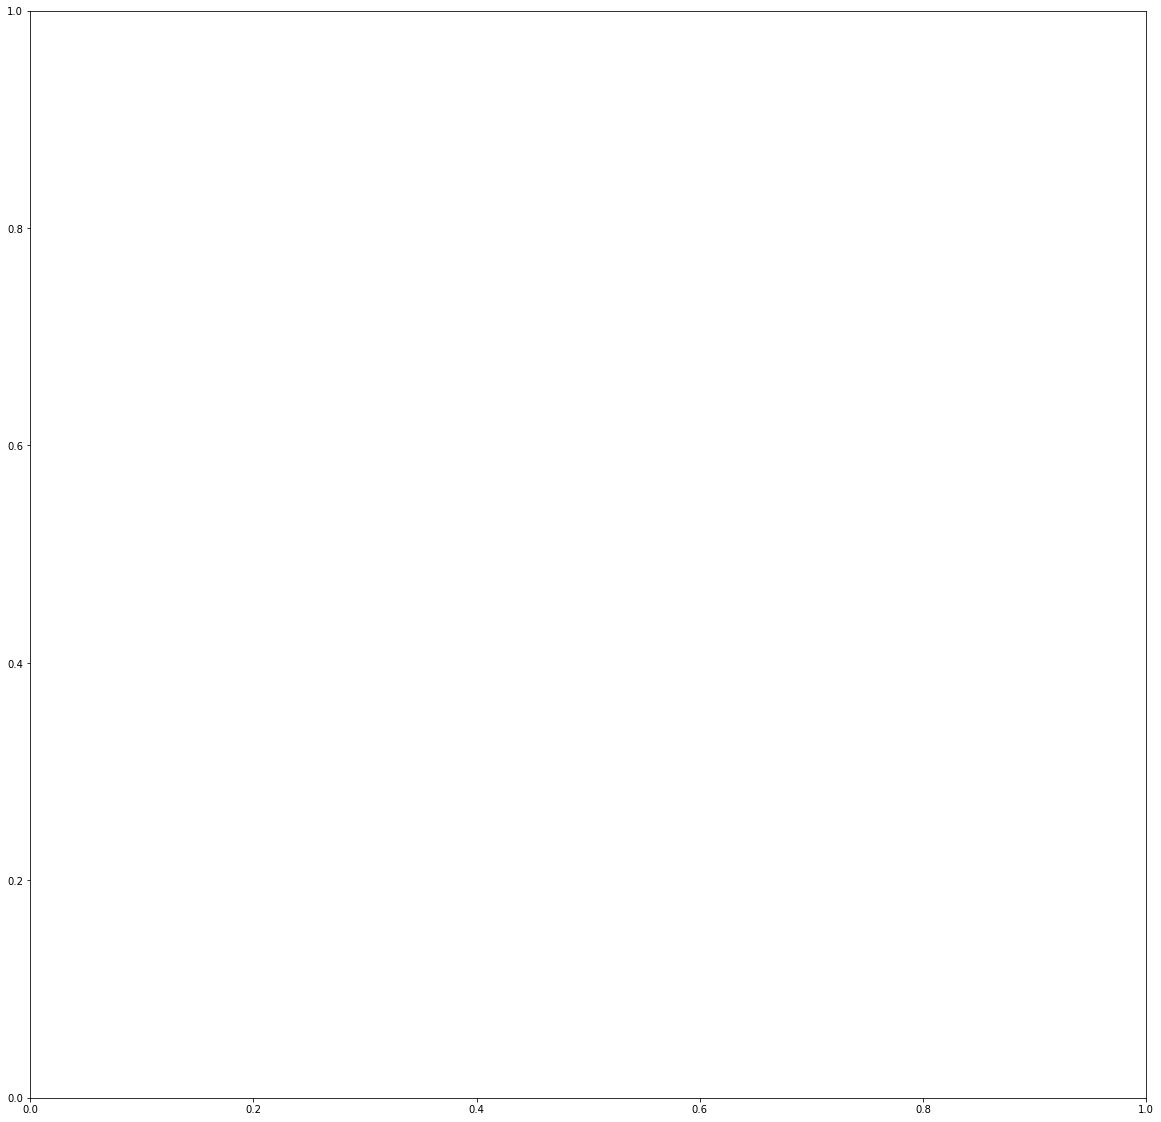

In [6]:
fig,axis = plt.subplots(1,1,figsize=(20,20))
axis.imshow(frame)

In [7]:
def plot_real_data_sagital():
    ###### REAL DATA ####
    a = np.array([19.33,18.92,18.45,17.94,17.3,16.4,15.18,13.67,11.97,10.21,8.48,6.74,4.94,3.13,1.42,-0.13,-1.54,-2.87,-4.12,-5.3,-6.4,-7.43,-8.39,-9.27,-10.02,
    -10.61,-10.95,-10.91,-10.31,-9,-6.95,-4.25,-1.05,2.42,5.93,9.22,12.11,14.55,16.53,18.13,19.45,20.54,21.38,21.84,21.87,21.5,20.84,20.09,19.5,19.18,19.01,])


    c = np.array([3.97,7,10.59,14.12,17.38,19.84,21.27,21.67,21.22,20.2,18.86,17.35,15.73,14.08,12.5,11.09,9.91,8.97,8.28,
    7.86,7.72,7.94,8.6,9.76,11.5,13.86,16.97,20.96,26,32.03,38.74,45.6,52.05,57.54,61.66,64.12,64.86,63.95,61.59,57.97,
    53.27,47.58,40.94,33.46,25.38,17.27,9.94,4.31,1.12,0.54,2.21
    ])
    b = np.array([38.12,44,49.78,55.9,60.43,64.34,67.9,74,78,82,84,82.65,78,70.09,64.78,58.98,52.34,46.94,40.62,34.98,28.76,22.12,
    16.97,14,13.45,15.9,19.14,21.79,24.05,28,30,30,30,30,30,28,26,24,22,19,15,13,12,11,11,12,15,19,22,27,30])


    d = np.array([4.19,4.58,4.79,4.98,5.11,5.12,5.17,5.34,5.61,5.85,5.95,5.85,5.57,5.18,4.84,4.69,4.64,4.66,4.74,4.86,4.95,4.98,4.97,
    4.96,4.97,5.05,5.22,5.49,5.86,6.2,6.3,6.05,5.53,4.99,4.75,4.93,5.41,5.99,6.51,6.93,7.22,7.42,7.55,7.54,7.29,6.69,5.73,4.54,3.55,3.28,3.6,])

    d = np.array([0.02,-2.06,-3.88,-4.6,-3.98,-2.4,-0.45,1.45,3.04,4.27,5.13,5.71,6.1,6.43,6.76,7.12,7.54,7.99,8.44,8.86,9.23,9.51,9.62,
    9.43,8.7,7.2,4.69,1.15,-3.26,-8.17,-13.05,-17.13,-19.52,-19.77,-18.12,-15.29,-12.04-8.85,-5.96,-3.51,-1.64,
    -0.5,-0.07,-0.16,-0.42,-0.52,-0.26,0.36,1,1.2,0.58])



    e = np.array([0.02,-2.06,-3.88,-4.6,-3.98,-2.4,-0.45,1.45,3.04,4.27,5.13,5.71,6.1,6.43,6.76,7.12,7.54,7.99,8.44,8.86,9.23,9.51,
    9.62,9.43,8.7,7.2,4.69,1.15,-3.26,-8.17,-13.05,-17.13,-19.52,-19.77,-18.12,-15.29,-12.04,-8.85,-5.96,-3.51,-1.64,-0.5,-0.07,-0.16,
    -0.42,-0.52,-0.26,0.36,1,1.2,0.58,])
  
    figure, ax = plt.subplots(1,5,figsize=(20,4))
    ax[0].plot(np.array(a))
    ax[0].set_title("Cadera")
    ax[0].grid("on")
    ax[1].plot(c)
    ax[1].set_title("Rodilla Derecha")
    ax[1].grid("on")
    ax[2].plot(b)
    ax[2].set_title("Rodilla Izquierda")
    ax[2].grid("on")
    ax[3].plot(d)
    ax[3].set_title("Pie Derecho")

    ax[3].grid("on")
    ax[4].plot(e)
    ax[4].set_title("Pie izquierdo")
    ax[4].grid("on")

In [8]:
def plot_real_data_frontal():
    a = np.array([0,-3.3,-5,-4.05,-1.9,0,0.6,5.1,7,6.45,3.5,1,0.5])
    b = np.array([0,3,5,4,4,3,3,3,3,3,5,5,4,6,7,9,12,11,3,3,3])
    c = np.array([5,-1,-1,-1,-1,-1,-1,-1,-1,-1,3,5,3,1,1,1,1,1,2,5,3])
    figure, ax = plt.subplots(1,5,figsize=(20,4))
    ax[0].plot(np.array(a))
    ax[0].set_title("Cadera")
    ax[0].grid("on")
    ax[1].plot(b)
    ax[1].set_title("Rodilla Derecha")
    ax[1].grid("on")
    ax[2].plot(b)
    ax[2].set_title("Rodilla Izquierda")
    ax[2].grid("on")
    ax[3].plot(c)
    ax[3].set_title("Pie Derecho")

    ax[3].grid("on")
    ax[4].plot(c)
    ax[4].set_title("Pie izquierdo")
    ax[4].grid("on")

In [27]:
def digital_goniomertry(video_path,video_path2,th,scale_percent=80,version= "sticky",line="conitnues"):
    global frame 
    global height 
    ### X POSITION ##
    global k_rx  
    global h_rx 
    global a_rx  
    global k_lx 
    global h_lx
    global a_lx  
    ## Y position ##
    global k_ry  
    global h_ry 
    global a_ry  
    global k_ly  
    global h_ly 
    global a_ly  


    ## ANGLES ##
    angles_r  = []  # Store trayectories of angles for right knee
    angles_c  = []  # Store trayectories of angles for right Hip
    angles_t  = []  # Store trayectories of angles for right  Ankle
    angles_r2 = []  # Store trayectories of angles for left knee
    angles_c2 = []  # Store trayectories of angles for left Hip
    angles_t2 = []  # Store trayectories of angles for left  Ankle
    
    # X POSITION ##
    k_rx  = []  # Store trayectories of angles for right knee
    h_rx  = []  # Store trayectories of angles for right Hip
    a_rx  = []  # Store trayectories of angles for right  Ankle
    k_lx  = []  # Store trayectories of angles for left knee
    h_lx  = []  # Store trayectories of angles for left Hip
    a_lx  = []  # Store trayectories of angles for left  Ankle
    
    ## Y position ##
    k_ry  = []  # Store trayectories of angles for right knee
    h_ry  = []  # Store trayectories of angles for right Hip
    a_ry  = []  # Store trayectories of angles for right  Ankle
    k_ly  = []  # Store trayectories of angles for left knee
    h_ly  = []  # Store trayectories of angles for left Hip
    a_ly  = []  # Store trayectories of angles for left  Ankle
    
    ## SPECIAL (FOR CENTER OF MASS) ##
    positionx = []  # Store x trayectories o center of mass
    positiony = []  # Store y trayectories o center of mass
  
    ### stethic stuff ###
    font                    =  0
    bottomLeftCornerOfText  = (20,20)
    bottomLeftCornerOfText2 = (20,40)
    bottomLeftCornerOfText3 = (20,60)
    bottomRightCornerOfText = (250,20)
    bottomRightCornerOfText2= (250,40)
    bottomRightCornerOfText3= (250,60)
    fontScale               = 0.4
    fontColor               = (255,255,255)
    lineType                = 1
  
    #####################
    status = True                            # Variable to iterate over frames
    initialization = True 
    capture  = cv2.VideoCapture(video_path)  # load video for right
    capture2 = cv2.VideoCapture(video_path2) # Load video for left 
    while status:                            # While loop 
        status,frame = capture.read()        # Reads video, returns (status,frame) right 
        status,frame2 = capture2.read()        # Reads video,returns (status,frame) left
        if status == True:                   # If there is a frame
            if initialization:
                ### Obtain shapes in order to do scaling ###
                width = int(frame.shape[1]*scale_percent / 100)
                height = int(frame.shape[0]*scale_percent / 100)        
                dim = (width, height)
                
            frame =  cv2.resize(frame, dim, interpolation = cv2.INTER_AREA) # Rescale video
            frame2=  cv2.resize(frame2, dim, interpolation = cv2.INTER_AREA) # Rescale 
            ### Obtain frames by channel (BGR) Right  ###
            M_cadera,rc  =  color_mask(frame,th,color="red")     # Obtain Mask for Cadera (Red channel)
            M_rodilla,bc =  color_mask(frame,th,color="blue")    # Obtain Mask for Rodilla (Blue channel)
            M_tobillo,gc =  color_mask(frame,th,color="green")   # Obtain Mask for tobillo (Green Channel)
            cadera  =  M_cadera*frame[:,:,rc]                    # Obtain frame for cadera
            rodilla =  M_rodilla*frame[:,:,bc]                   # Obtain frame for rodilla
            tobillo =  M_tobillo*frame[:,:,gc]                   # Obtain frame for tobillo
            
            ### Obtain frames by channel (BGR) Leftt  ###
            M_cadera2,rc2  =  color_mask(frame2,th,color="red")     # Obtain Mask for Cadera (Red channel)
            M_rodilla2,bc2 =  color_mask(frame2,th,color="blue")    # Obtain Mask for Rodilla (Blue channel)
            M_tobillo2,gc2 =  color_mask(frame2,th,color="green")   # Obtain Mask for tobillo (Green Channel)
            cadera2  =  M_cadera2*frame2[:,:,rc2]                    # Obtain frame for cadera
            rodilla2 =  M_rodilla2*frame2[:,:,bc2]                   # Obtain frame for rodilla
            tobillo2 =  M_tobillo2*frame2[:,:,gc2]                   # Obtain frame for tobillo
            
            ### Obtian the countrors of every image  Right ###
            contours_c, hierarchy = cv2.findContours(cadera,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Get contours
            contours_r, hierarchy = cv2.findContours(rodilla,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Get contours
            contours_t, hierarchy = cv2.findContours(tobillo,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Get contours
            contours=  [contours_c[0],contours_r[0],contours_t[0]]
            
            ### Obtian the countrors of every image  Left ###
            contours_c2, hierarchy = cv2.findContours(cadera2,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Get contours
            contours_r2, hierarchy = cv2.findContours(rodilla2,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Get contours
            contours_t2, hierarchy = cv2.findContours(tobillo2,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Get contours
            contours2=  [contours_c2[0],contours_r2[0],contours_t2[0]]
            
            ### Obtian Centroids Right  ###
            CX,CY = find_centroids(contours)
            Centroids_cadera  = np.array([CX[0],CY[0]])                    # From image
            Centroids_rodilla = np.array([CX[1],CY[1]])                    # From image
            Centroids_tobillo = np.array([CX[2],CY[2]])                    # From image
            ### Obtain cetnroids using anatomic truth ###
            Centroids_masa =    np.array([CX[0],int(CY[0] - .40*CY[0])])   # Created from data
            Centroids_feet =    np.array([CX[2],int(CY[2] + .040*CY[2])])   # Created from data 
            

            
            ### Obtian Centroids Left ###
            CX2,CY2 = find_centroids(contours2)
            Centroids_cadera2  = np.array([CX2[0],CY2[0]])                    # From image
            Centroids_rodilla2 = np.array([CX2[1],CY2[1]])                    # From image
            Centroids_tobillo2 = np.array([CX2[2],CY2[2]])                    # From image
            ### Obtain cetnroids using anatomic truth ###
            Centroids_feet2 =    np.array([CX2[2],int(CY2[2] + .040*CY2[2])])   # Created from data 
            
            
            ### append centroid coordiantes for 3d plot ###
            ### X POSITION ###
            k_rx.append(Centroids_rodilla[0])  # Store trayectories of angles for right knee
            h_rx.append(Centroids_cadera[0])   # Store trayectories of angles for right Hip
            a_rx.append(Centroids_tobillo[0])  # Store trayectories of angles for right  Ankle
            k_lx.append(Centroids_rodilla2[0])   # Store trayectories of angles for left knee
            h_lx.append(Centroids_cadera2[0])   # Store trayectories of angles for left Hip
            a_lx.append(Centroids_tobillo2[0])   # Store trayectories of angles for left  Ankle

            ### Y position ###
            k_ry.append(-1*Centroids_rodilla[1] + height) # Store trayectories of angles for right knee
            h_ry.append(-1*Centroids_cadera[1]  + height) # Store trayectories of angles for right Hip
            a_ry.append(-1*Centroids_tobillo[1] + height) # Store trayectories of angles for right  Ankle
            k_ly.append(-1*Centroids_rodilla2[1]+ height) # Store trayectories of angles for left knee
            h_ly.append(-1*Centroids_cadera2[1] + height) # Store trayectories of angles for left Hip
            a_ly.append(-1*Centroids_tobillo2[1]+ height) # Store trayectories of angles for left  Ankle
            
            
            if version == "sticky":
                frame = frame*0 + 255
                frame2 = frame2*0 + 255
                fontColor = (0,0,0)
                    
            elif version == "normal":
                pass

            
            ### Draw centroids Ritght ###                                       #B    G   R
            cv2.circle(frame , (Centroids_cadera[0],  Centroids_cadera[1]),  3, (0,   0, 255), -1) # Cadera
            cv2.circle(frame , (Centroids_rodilla[0], Centroids_rodilla[1]), 3, (255, 0,   0), -1) # Rodilla
            cv2.circle(frame , (Centroids_tobillo[0], Centroids_tobillo[1]), 3, (0,  255,  0), -1) # tobillo
            cv2.circle(frame , (Centroids_feet[0], Centroids_feet[1]), 3,fontColor, -1)
            ### Draw centroids Left ###                                            #B    G   R
            cv2.circle(frame , (Centroids_cadera2[0],  Centroids_cadera2[1]),  3, (0,   0, 255), -1) # Cadera
            cv2.circle(frame , (Centroids_rodilla2[0], Centroids_rodilla2[1]), 3, (255, 0,   0), -1) # Rodilla
            cv2.circle(frame , (Centroids_tobillo2[0], Centroids_tobillo2[1]), 3, (0,  255,  0), -1) # tobillo
            cv2.circle(frame , (Centroids_feet2[0], Centroids_feet2[1]), 3,fontColor, -1)
            
            ### Mass ceneter (sagital plane) ###
            cv2.circle(frame , (Centroids_masa[0],  Centroids_masa[1]),  4, (255,   0, 255), -1)         # Centro de masa
            
            
            
            ### Draw lines  Right ###
            cv2.line(frame,(Centroids_masa[0], Centroids_masa[1]),(Centroids_cadera[0], Centroids_cadera[1]),fontColor, 1) 
            cv2.line(frame,(Centroids_cadera[0], Centroids_cadera[1]),(Centroids_rodilla[0], Centroids_rodilla[1]), fontColor, 1) 
            cv2.line(frame,(Centroids_rodilla[0], Centroids_rodilla[1]),(Centroids_tobillo[0], Centroids_tobillo[1]), fontColor,1) 
            cv2.line(frame,(Centroids_tobillo[0], Centroids_tobillo[1]),(Centroids_feet[0], Centroids_feet[1]), fontColor, 1) 
            
            ### Draw lines  Left ###
            cv2.line(frame,(Centroids_masa[0], Centroids_masa[1]),(Centroids_cadera2[0], Centroids_cadera2[1]),fontColor, 1) 
            cv2.line(frame,(Centroids_cadera2[0], Centroids_cadera2[1]),(Centroids_rodilla2[0], Centroids_rodilla2[1]), fontColor, 1) 
            cv2.line(frame,(Centroids_rodilla2[0], Centroids_rodilla2[1]),(Centroids_tobillo2[0], Centroids_tobillo2[1]), fontColor,1) 
            cv2.line(frame,(Centroids_tobillo2[0], Centroids_tobillo2[1]),(Centroids_feet2[0], Centroids_feet2[1]), fontColor, 1) 
            
            
            ### Draw movement of center of mass ###
            positionx.append(Centroids_masa[0])
            positiony.append(Centroids_masa[1])
            for px,py in zip(positionx,positiony):            # iterate over points collected
                cv2.circle(frame , (px, py), 1,fontColor, -1) # Draw all of them in current frame

                
                
            ### Tell user about angles  RIght ###
            ################## ANGLE IN HIPPS ###################
            v1 = Centroids_masa    - Centroids_cadera 
            v2 = Centroids_rodilla -  Centroids_cadera 
            s=-1
            if Centroids_rodilla[0] > Centroids_cadera[0]:
                s=1
            angle_cadera = s*(180 -  angle_between_vectors(v1,v2))
            angles_c.append(angle_cadera)
            msg_cadera = f"Right Hipp angle: {round(angle_cadera,2) }"
    
            ################## ANGLE IN Knee ###################
            v1 = Centroids_tobillo - Centroids_rodilla
            v2 = Centroids_cadera  - Centroids_rodilla
            angle_rodilla = 180 - angle_between_vectors(v1,v2)
            angles_r.append(angle_rodilla)
            msg_rodilla = f"Right Knee angle: {round(angle_rodilla,2) }"
            
            ################## ANGLE IN Ankle ###################
            v1 = Centroids_rodilla - Centroids_tobillo 
            v2 = Centroids_feet    - Centroids_tobillo 
            s=1
            if Centroids_rodilla2[0] > Centroids_tobillo2[0]:
                s=-1
            angle_tobillo =s*(180 -  angle_between_vectors(v1,v2))
            angles_t.append(angle_tobillo)
            msg_tobillo = f"Right Ankle angle: {round(angle_tobillo,2) }"
            ########################################################
            
            ### Tell user about angles  left ###
            ################## ANGLE IN HIPPS ###################
            v1 = Centroids_masa    - Centroids_cadera2 
            v2 = Centroids_rodilla2 -  Centroids_cadera2 
            angle_cadera2 =180 - angle_between_vectors(v1,v2)
            angles_c2.append(angle_cadera2)
            msg_cadera2 = f"Left Hipp angle: {round(angle_cadera2,2) }"
    
            ################## ANGLE IN Knee ###################
            v1 = Centroids_tobillo2 - Centroids_rodilla2
            v2 = Centroids_cadera2  - Centroids_rodilla2
            angle_rodilla2 =180 - angle_between_vectors(v1,v2)
            angles_r2.append(angle_rodilla2)
            msg_rodilla2 = f"Left Knee angle: {round(angle_rodilla2,2) }"
            
            ################## ANGLE IN Ankle ###################
            v1 = Centroids_rodilla2 - Centroids_tobillo2 
            v2 = Centroids_feet2    - Centroids_tobillo2 
            s=-1
            if Centroids_rodilla2[0] > Centroids_tobillo2[0]:
                s=1
            angle_tobillo2 =s*(180 - angle_between_vectors(v1,v2))
            angles_t2.append(angle_tobillo2)
            msg_tobillo2 = f"Left Ankle angle: {round(angle_tobillo2,2) }"
            ########################################################
            
            time.sleep(0.2)
            cv2.putText(frame,str(msg_rodilla), bottomLeftCornerOfText,font, fontScale,fontColor,lineType)
            cv2.putText(frame,str(msg_cadera),  bottomLeftCornerOfText2,font, fontScale,fontColor,lineType)
            cv2.putText(frame,str(msg_tobillo ),bottomLeftCornerOfText3,font, fontScale,fontColor,lineType)
            cv2.putText(frame,str(msg_rodilla2), bottomRightCornerOfText,font, fontScale,fontColor,lineType)
            cv2.putText(frame,str(msg_cadera2),  bottomRightCornerOfText2,font, fontScale,fontColor,lineType)
            cv2.putText(frame,str(msg_tobillo2),bottomRightCornerOfText3,font, fontScale,fontColor,lineType)
            cv2.imshow("Video",frame)
                
            
            
            if  initialization:      
                 initialization  = False # change state of initialization (only happens for first frame )
                

                
    #### This section of the code runs once we have porcessed all the video  ####
        if cv2.waitKey(1) & 0xFF == ord('q'): # If q is pressed 
            break                             # Break from while loop

    cv2.destroyAllWindows()                   # Destroy window
    capture.release()                         # Release video (free memory)
    
    ### MESSAGE FOR USERS RIght
    MAX = round(np.max(angles_c),2)
    MIN = round(np.min(angles_c),2)
    print(f"Right Hip ROM:  {MIN} - {MAX}")
    MAX = round(np.max(angles_r),2)
    MIN = round(np.min(angles_r),2)
    print(f"Right Knee ROM:  {MIN} - {MAX}")
    MAX = round(np.max(angles_t),2)
    MIN = round(np.min(angles_t),2)
    print(f"Right Ankle ROM:  {MIN} - {MAX}")
    print()
    ### MESSAGE FOR USERS LEft
    MAX = round(np.max(angles_c2),2)
    MIN = round(np.min(angles_c2),2)
    print(f"Left Hip ROM:  {MIN} - {MAX}")
    MAX = round(np.max(angles_r2),2)
    MIN = round(np.min(angles_r2),2)
    print(f"Left Knee ROM:  {MIN} - {MAX}")
    MAX = round(np.max(angles_t2),2)
    MIN = round(np.min(angles_t2),2)
    print(f"Left Ankle ROM:  {MIN} - {MAX}")
    print()
    MAX = round(np.max(positionx),2)
    MIN = round(np.min(positionx),2)
    displacement_of_mass = (MAX-MIN)*(132/width)
    print(f"Center of mass x movement:  {displacement_of_mass} cm ")

    return angles_c,angles_r,angles_t,angles_c2,angles_r2,angles_t2

In [28]:
def digital_goniomertry2(video_path,video_path2,th,scale_percent=80,version= "sticky",line="conitnues"):
    global frame 
    angles_r  = []  # Store trayectories of angles for right knee
    angles_c  = []  # Store trayectories of angles for right Hip
    angles_t  = []  # Store trayectories of angles for right  Ankle
    angles_r2 = []  # Store trayectories of angles for left knee
    angles_c2 = []  # Store trayectories of angles for left Hip
    angles_t2 = []  # Store trayectories of angles for left  Ankle
    positionx = []  # Store x trayectories o center of mass
    positiony = []  # Store y trayectories o center of mass
    
    ### stethic stuff ###
    font                    =  0
    bottomLeftCornerOfText  = (20,20)
    bottomLeftCornerOfText2 = (20,40)
    bottomLeftCornerOfText3 = (20,60)
    bottomRightCornerOfText = (250,20)
    bottomRightCornerOfText2= (250,40)
    bottomRightCornerOfText3= (250,60)
    fontScale               = 0.4
    fontColor               = (255,255,255)
    lineType                = 1
    #####################
    status = True                            # Variable to iterate over frames
    initialization = True 
    capture  = cv2.VideoCapture(video_path)  # load video for right
    capture2 = cv2.VideoCapture(video_path2) # Load video for left 
    while status:                            # While loop 
        status,frame = capture.read()        # Reads video, returns (status,frame) right 
        status,frame2 = capture2.read()        # Reads video,returns (status,frame) left
        if status == True:                   # If there is a frame
            if initialization:
                ### Obtain shapes in order to do scaling ###
                width = int(frame.shape[1]*scale_percent / 100)
                height = int(frame.shape[0]*scale_percent / 100)        
                dim = (width, height)
                
            frame =  cv2.resize(frame, dim, interpolation = cv2.INTER_AREA) # Rescale video
            frame2=  cv2.resize(frame2, dim, interpolation = cv2.INTER_AREA) # Rescale 
            ### Obtain frames by channel (BGR) Right  ###
            M_cadera,rc  =  color_mask(frame,th,color="red")     # Obtain Mask for Cadera (Red channel)
            M_rodilla,bc =  color_mask(frame,th,color="blue")    # Obtain Mask for Rodilla (Blue channel)
            M_tobillo,gc =  color_mask(frame,th,color="green")   # Obtain Mask for tobillo (Green Channel)
            cadera  =  M_cadera*frame[:,:,rc]                    # Obtain frame for cadera
            rodilla =  M_rodilla*frame[:,:,bc]                   # Obtain frame for rodilla
            tobillo =  M_tobillo*frame[:,:,gc]                   # Obtain frame for tobillo
            
            ### Obtain frames by channel (BGR) Leftt  ###
            M_cadera2,rc2  =  color_mask(frame2,th,color="red")     # Obtain Mask for Cadera (Red channel)
            M_rodilla2,bc2 =  color_mask(frame2,th,color="blue")    # Obtain Mask for Rodilla (Blue channel)
            M_tobillo2,gc2 =  color_mask(frame2,th,color="green")   # Obtain Mask for tobillo (Green Channel)
            cadera2  =  M_cadera2*frame2[:,:,rc2]                    # Obtain frame for cadera
            rodilla2 =  M_rodilla2*frame2[:,:,bc2]                   # Obtain frame for rodilla
            tobillo2 =  M_tobillo2*frame2[:,:,gc2]                   # Obtain frame for tobillo
            
            ### Obtian the countrors of every image  Right ###
            contours_c, hierarchy = cv2.findContours(cadera,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Get contours
            contours_r, hierarchy = cv2.findContours(rodilla,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Get contours
            contours_t, hierarchy = cv2.findContours(tobillo,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Get contours
            contours=  [contours_c[0],contours_r[0],contours_t[0]]
            
            ### Obtian the countrors of every image  Left ###
            contours_c2, hierarchy = cv2.findContours(cadera2,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Get contours
            contours_r2, hierarchy = cv2.findContours(rodilla2,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Get contours
            contours_t2, hierarchy = cv2.findContours(tobillo2,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Get contours
            contours2=  [contours_c2[0],contours_r2[0],contours_t2[0]]
            
            ### Obtian Centroids Right  ###
            CX,CY = find_centroids(contours)
            Centroids_cadera  = np.array([CX[0],CY[0]])                    # From image
            Centroids_rodilla = np.array([CX[1],CY[1]])                    # From image
            Centroids_tobillo = np.array([CX[2],CY[2]])                    # From image
            ### Obtain cetnroids using anatomic truth ###
            
            Centroids_feet =    np.array([CX[2],int(CY[2] + .040*CY[2])])   # Created from data 
            
            ### Obtian Centroids Left ###
            CX2,CY2 = find_centroids(contours2)
            Centroids_cadera2  = np.array([CX2[0],CY2[0]])                    # From image
            Centroids_rodilla2 = np.array([CX2[1],CY2[1]])                    # From image
            Centroids_tobillo2 = np.array([CX2[2],CY2[2]])                    # From image
            ### Obtain cetnroids using anatomic truth ###
            Centroids_feet2 =    np.array([CX2[2],int(CY2[2] + .040*CY2[2])])   # Created from data 
            
            Centroids_masa =    np.array([int(0.5*CX[0]+0.5*CX2[0]),int(CY[0] - .50*CY[0])])   # Created from data
                      
            if version == "sticky":
                frame = frame*0 + 255
                frame2 = frame2*0 + 255
                fontColor = (0,0,0)
                    
            elif version == "normal":
                pass

            
            ### Draw centroids Ritght ###                                       #B    G   R
            cv2.circle(frame , (Centroids_cadera[0],  Centroids_cadera[1]),  3, (0,   0, 255), -1) # Cadera
            cv2.circle(frame , (Centroids_rodilla[0], Centroids_rodilla[1]), 3, (255, 0,   0), -1) # Rodilla
            cv2.circle(frame , (Centroids_tobillo[0], Centroids_tobillo[1]), 3, (0,  255,  0), -1) # tobillo
            cv2.circle(frame , (Centroids_feet[0], Centroids_feet[1]), 3,fontColor, -1)
            ### Draw centroids Left ###                                            #B    G   R
            cv2.circle(frame , (Centroids_cadera2[0],  Centroids_cadera2[1]),  3, (0,   0, 255), -1) # Cadera
            cv2.circle(frame , (Centroids_rodilla2[0], Centroids_rodilla2[1]), 3, (255, 0,   0), -1) # Rodilla
            cv2.circle(frame , (Centroids_tobillo2[0], Centroids_tobillo2[1]), 3, (0,  255,  0), -1) # tobillo
            cv2.circle(frame , (Centroids_feet2[0], Centroids_feet2[1]), 3,fontColor, -1)
            
            ### Mass ceneter (sagital plane) ###
            cv2.circle(frame , (Centroids_masa[0],  Centroids_masa[1]),  4, (255,   0, 255), -1)         # Centro de masa
            
            
            
            ### Draw lines  Right ###
            cv2.line(frame,(Centroids_masa[0], Centroids_masa[1]),(Centroids_cadera[0], Centroids_cadera[1]),fontColor, 1) 
            cv2.line(frame,(Centroids_cadera[0], Centroids_cadera[1]),(Centroids_rodilla[0], Centroids_rodilla[1]), fontColor, 1) 
            cv2.line(frame,(Centroids_rodilla[0], Centroids_rodilla[1]),(Centroids_tobillo[0], Centroids_tobillo[1]), fontColor,1) 
            cv2.line(frame,(Centroids_tobillo[0], Centroids_tobillo[1]),(Centroids_feet[0], Centroids_feet[1]), fontColor, 1) 
            
            ### Draw lines  Left ###
            cv2.line(frame,(Centroids_masa[0], Centroids_masa[1]),(Centroids_cadera2[0], Centroids_cadera2[1]),fontColor, 1) 
            cv2.line(frame,(Centroids_cadera2[0], Centroids_cadera2[1]),(Centroids_rodilla2[0], Centroids_rodilla2[1]), fontColor, 1) 
            cv2.line(frame,(Centroids_rodilla2[0], Centroids_rodilla2[1]),(Centroids_tobillo2[0], Centroids_tobillo2[1]), fontColor,1) 
            cv2.line(frame,(Centroids_tobillo2[0], Centroids_tobillo2[1]),(Centroids_feet2[0], Centroids_feet2[1]), fontColor, 1) 
            
            
            ### Draw movement of center of mass ###
            positionx.append(Centroids_masa[0])
            positiony.append(Centroids_masa[1])
            for px,py in zip(positionx,positiony):            # iterate over points collected
                cv2.circle(frame , (px, py), 1,fontColor, -1) # Draw all of them in current frame

                
                
            ### Tell user about angles  RIght ###
            ################## ANGLE IN HIPPS ###################
            v1 = Centroids_masa    - Centroids_cadera 
            v2 = Centroids_rodilla -  Centroids_cadera 
            angle_cadera = 180 -  angle_between_vectors(v1,v2)
            angles_c.append(angle_cadera)
            msg_cadera = f"Right Hipp angle: {round(angle_cadera,2) }"
    
            ################## ANGLE IN Knee ###################
            v1 = Centroids_tobillo - Centroids_rodilla
            v2 = Centroids_cadera  - Centroids_rodilla
            angle_rodilla = 180 - angle_between_vectors(v1,v2)
            angles_r.append(angle_rodilla)
            msg_rodilla = f"Right Knee angle: {round(angle_rodilla,2) }"
            
            ################## ANGLE IN Ankle ###################
            v1 = Centroids_rodilla - Centroids_tobillo 
            v2 = Centroids_feet    - Centroids_tobillo 
            angle_tobillo =180 -  angle_between_vectors(v1,v2)
            angles_t.append(angle_tobillo)
            msg_tobillo = f"Right Ankle angle: {round(angle_tobillo,2) }"
            ########################################################
            
            ### Tell user about angles  left ###
            ################## ANGLE IN HIPPS ###################
            v1 = Centroids_masa    - Centroids_cadera2 
            v2 = Centroids_rodilla2 -  Centroids_cadera2 
            angle_cadera2 =180 - angle_between_vectors(v1,v2)
            angles_c2.append(angle_cadera2)
            msg_cadera2 = f"Left Hipp angle: {round(angle_cadera2,2) }"
    
            ################## ANGLE IN Knee ###################
            v1 = Centroids_tobillo2 - Centroids_rodilla2
            v2 = Centroids_cadera2  - Centroids_rodilla2
            angle_rodilla2 =180 - angle_between_vectors(v1,v2)
            angles_r2.append(angle_rodilla2)
            msg_rodilla2 = f"Left Knee angle: {round(angle_rodilla2,2) }"
            
            ################## ANGLE IN Ankle ###################
            v1 = Centroids_rodilla2 - Centroids_tobillo2 
            v2 = Centroids_feet2    - Centroids_tobillo2 
            angle_tobillo2 =180 - angle_between_vectors(v1,v2)
            angles_t2.append(angle_tobillo2)
            msg_tobillo2 = f"Left Ankle angle: {round(angle_tobillo2,2) }"
            ########################################################
            
            time.sleep(0.2)
            cv2.putText(frame,str(msg_rodilla), bottomLeftCornerOfText,font, fontScale,fontColor,lineType)
            cv2.putText(frame,str(msg_cadera),  bottomLeftCornerOfText2,font, fontScale,fontColor,lineType)
            cv2.putText(frame,str(msg_tobillo ),bottomLeftCornerOfText3,font, fontScale,fontColor,lineType)
            cv2.putText(frame,str(msg_rodilla2), bottomRightCornerOfText,font, fontScale,fontColor,lineType)
            cv2.putText(frame,str(msg_cadera2),  bottomRightCornerOfText2,font, fontScale,fontColor,lineType)
            cv2.putText(frame,str(msg_tobillo2),bottomRightCornerOfText3,font, fontScale,fontColor,lineType)
            cv2.imshow("Video",frame)
                
            
            
            if  initialization:      
                 initialization  = False # change state of initialization (only happens for first frame )
                

                
    #### This section of the code runs once we have porcessed all the video  ####
        if cv2.waitKey(1) & 0xFF == ord('q'): # If q is pressed 
            break                             # Break from while loop

    cv2.destroyAllWindows()                   # Destroy window
    capture.release()                         # Release video (free memory)
    
    ### MESSAGE FOR USERS RIght
    MAX = round(np.max(angles_c),2)
    MIN = round(np.min(angles_c),2)
    print(f"Right Hip ROM:  {MIN} - {MAX}")
    MAX = round(np.max(angles_r),2)
    MIN = round(np.min(angles_r),2)
    print(f"Right Knee ROM:  {MIN} - {MAX}")
    MAX = round(np.max(angles_t),2)
    MIN = round(np.min(angles_t),2)
    print(f"Right Ankle ROM:  {MIN} - {MAX}")
    print()
    ### MESSAGE FOR USERS LEft
    MAX = round(np.max(angles_c2),2)
    MIN = round(np.min(angles_c2),2)
    print(f"Left Hip ROM:  {MIN} - {MAX}")
    MAX = round(np.max(angles_r2),2)
    MIN = round(np.min(angles_r2),2)
    print(f"Left Knee ROM:  {MIN} - {MAX}")
    MAX = round(np.max(angles_t2),2)
    MIN = round(np.min(angles_t2),2)
    print(f"Left Ankle ROM:  {MIN} - {MAX}")
    print()
    MAX = round(np.max(positionx),2)
    MIN = round(np.min(positionx),2)
    displacement_of_mass = (MAX-MIN)*(132/width)
    print(f"Center of mass x movement:  {displacement_of_mass} cm ")

    return angles_c,angles_r,angles_t,angles_c2,angles_r2,angles_t2

# Luis Sagital

In [45]:
video_path =  'utils\\luis\\Luis_sagital_Pierna derecha.mp4'
video_path2 =  'utils\\luis\\Luis_sagital_Pierna izquierda.mp4'
th = 230
angles_c,angles_r,angles_t,angles_c2,angles_r2,angles_t2 =  digital_goniomertry(video_path,video_path2,th,scale_percent=90,version= "sticky",line="conitnues")

Right Hip ROM:  0.42 - 21.88
Right Knee ROM:  0.14 - 7.94
Right Ankle ROM:  -17.74 - -0.57

Left Hip ROM:  1.55 - 35.64
Left Knee ROM:  21.72 - 65.17
Left Ankle ROM:  16.09 - 41.03

Center of mass x movement:  18.537037037037035 cm 


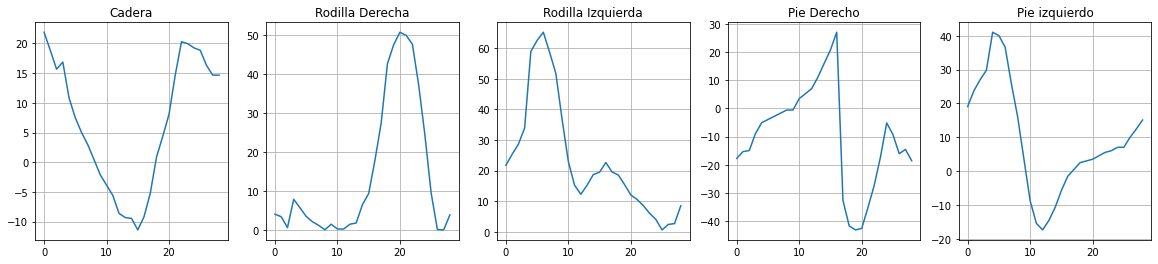

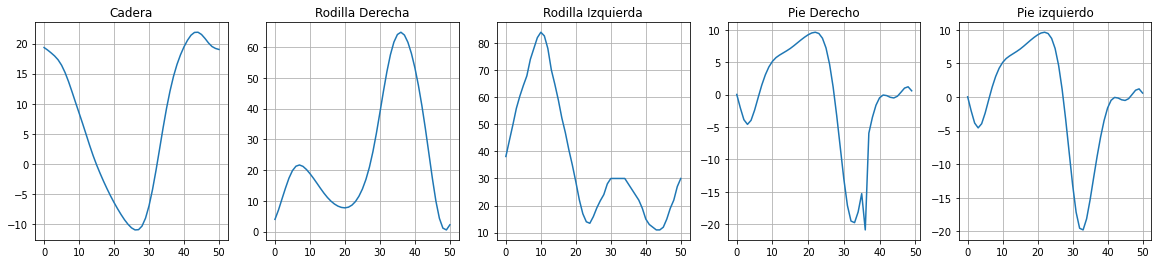

In [344]:
figure, ax = plt.subplots(1,5,figsize=(20,4))
ax[0].plot(np.array(angles_c))
ax[0].set_title("Cadera")
ax[0].grid("on")
ax[1].plot(angles_r)
ax[1].set_title("Rodilla Derecha")
ax[1].grid("on")
ax[2].plot(angles_r2)
ax[2].set_title("Rodilla Izquierda")
ax[2].grid("on")
ax[3].plot(angles_t)
ax[3].set_title("Pie Derecho")
ax[3].grid("on")
ax[4].plot(angles_t2)
ax[4].set_title("Pie izquierdo")
ax[4].grid("on")

plot_real_data_sagital()

# Luis Frontal

In [380]:
video_path =  'utils\\luis\\Luis_frontal_piernaDerecha.mp4'
video_path2 =  'utils\\luis\\Luis_frontal_piernaizquierda.mp4'
th = 100
angles_c,angles_r,angles_t,angles_c2,angles_r2,angles_t2 =  digital_goniomertry2(video_path,video_path2,th,scale_percent=90,version= "sticky",line="conitnues")

Right Hip ROM:  22.85 - 43.62
Right Knee ROM:  0.88 - 15.15
Right Ankle ROM:  0.0 - 14.16

Left Hip ROM:  22.88 - 52.83
Left Knee ROM:  0.06 - 11.64
Left Ankle ROM:  0.0 - 10.01

Center of mass x movement:  5.907407407407407 cm 


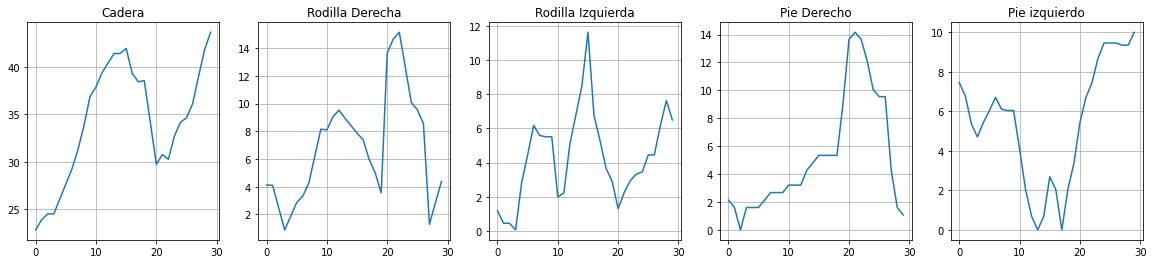

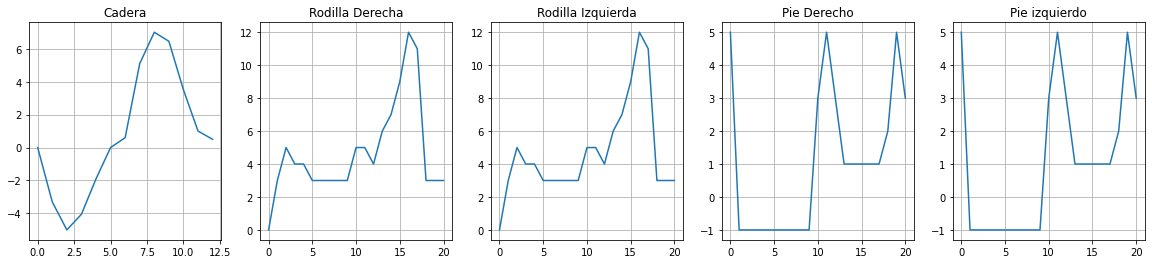

In [370]:
figure, ax = plt.subplots(1,5,figsize=(20,4))
ax[0].plot(np.array(angles_c))
ax[0].set_title("Cadera")
ax[0].grid("on")
ax[1].plot(angles_r)
ax[1].set_title("Rodilla Derecha")
ax[1].grid("on")
ax[2].plot(angles_r2)
ax[2].set_title("Rodilla Izquierda")
ax[2].grid("on")
ax[3].plot(angles_t)
ax[3].set_title("Pie Derecho")
ax[3].grid("on")
ax[4].plot(angles_t2)
ax[4].set_title("Pie izquierdo")
ax[4].grid("on")

###### REAL DATA ####
plot_real_data_frontal()

# Alejandro  Sagital

In [381]:
video_path =  'utils\\ale\\Alex_sagita_piernaderechal_1.mp4'
video_path2 =  'utils\\ale\\Alex_sagital_piernaizquierda_1.mp4'
th =120
angles_c,angles_r,angles_t,angles_c2,angles_r2,angles_t2 =  digital_goniomertry(video_path,video_path2,th,scale_percent=50,version= "sticky",line="conitnues")

Right Hip ROM:  -19.09 - 16.76
Right Knee ROM:  0.06 - 40.75
Right Ankle ROM:  -44.38 - 27.49

Left Hip ROM:  0.0 - 18.73
Left Knee ROM:  1.93 - 48.95
Left Ankle ROM:  -23.92 - 50.49

Center of mass x movement:  54.31250000000001 cm 


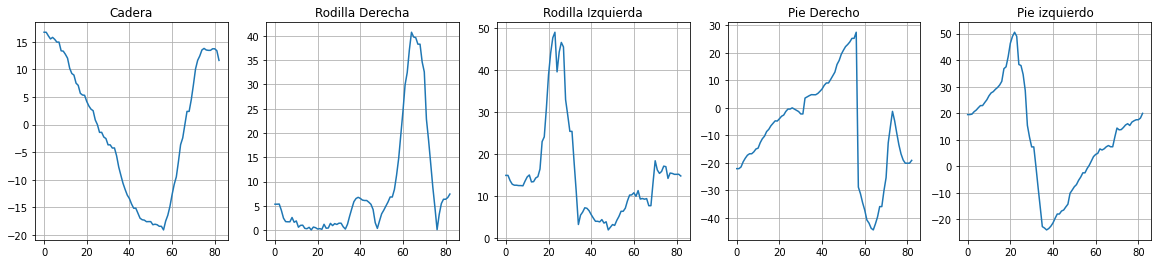

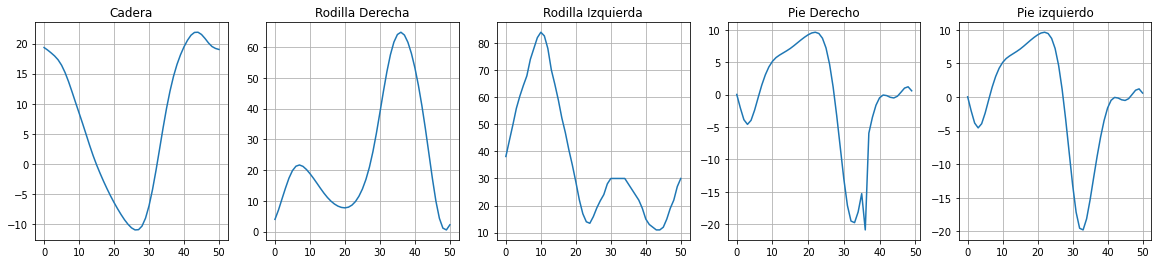

In [382]:
figure, ax = plt.subplots(1,5,figsize=(20,4))
ax[0].plot(np.array(angles_c))
ax[0].set_title("Cadera")
ax[0].grid("on")
ax[1].plot(angles_r)
ax[1].set_title("Rodilla Derecha")
ax[1].grid("on")
ax[2].plot(angles_r2)
ax[2].set_title("Rodilla Izquierda")
ax[2].grid("on")
ax[3].plot(angles_t)
ax[3].set_title("Pie Derecho")
ax[3].grid("on")
ax[4].plot(angles_t2)
ax[4].set_title("Pie izquierdo")
ax[4].grid("on")

###### REAL DATA ####
plot_real_data_sagital()

# Alejandro Frontal 

In [383]:
video_path =  'utils\\ale\\Alex_frontal_piernaderecha_1.mp4'
video_path2 =  'utils\\ale\\Alex_frontal_pierna_izquierda_1.mp4'
th =120
angles_c,angles_r,angles_t,angles_c2,angles_r2,angles_t2 =  digital_goniomertry2(video_path,video_path2,th,scale_percent=90,version= "sticky",line="conitnues")

Right Hip ROM:  47.06 - 53.1
Right Knee ROM:  2.24 - 40.8
Right Ankle ROM:  0.0 - 38.3

Left Hip ROM:  37.65 - 63.65
Left Knee ROM:  0.03 - 21.54
Left Ankle ROM:  0.29 - 22.68

Center of mass x movement:  8.631944444444445 cm 


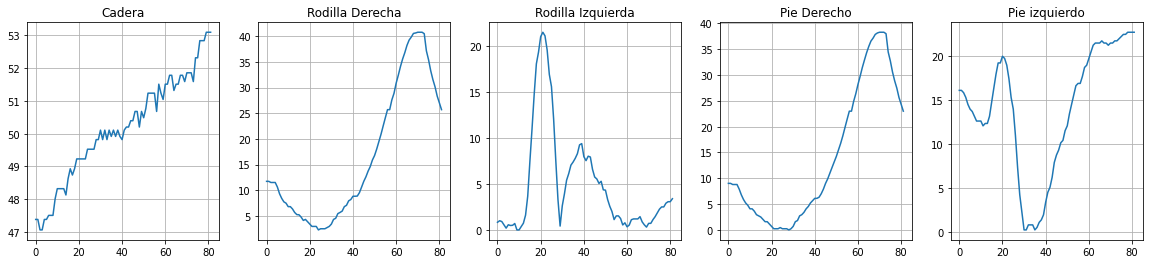

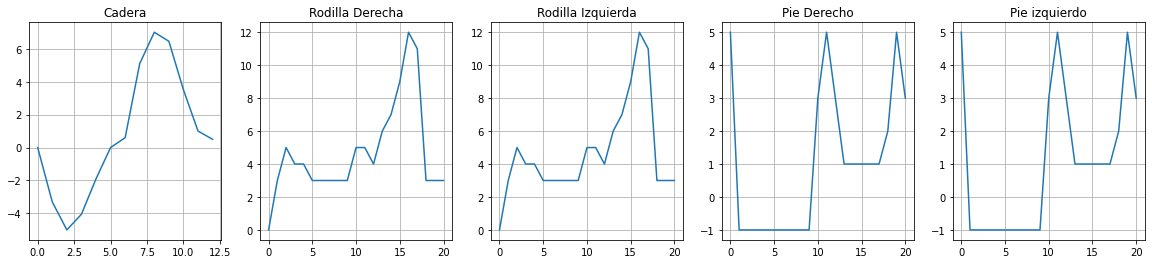

In [361]:
figure, ax = plt.subplots(1,5,figsize=(20,4))
ax[0].plot(np.array(angles_c))
ax[0].set_title("Cadera")
ax[0].grid("on")
ax[1].plot(angles_r)
ax[1].set_title("Rodilla Derecha")
ax[1].grid("on")
ax[2].plot(angles_r2)
ax[2].set_title("Rodilla Izquierda")
ax[2].grid("on")
ax[3].plot(angles_t)
ax[3].set_title("Pie Derecho")
ax[3].grid("on")
ax[4].plot(angles_t2)
ax[4].set_title("Pie izquierdo")
ax[4].grid("on")

###### REAL DATA ####
plot_real_data_frontal()

# Junior Sagital

In [384]:
video_path =  'utils\\junior\\Junior_Sagital_pierna_Derecha.mp4'
video_path2 =  'utils\\junior\\Junior_Sagital_pierna_Izq.mp4'
th =120
angles_c,angles_r,angles_t,angles_c2,angles_r2,angles_t2 =  digital_goniomertry(video_path,video_path2,th,scale_percent=90,version= "sticky",line="conitnues")

Right Hip ROM:  -32.39 - 6.2
Right Knee ROM:  0.1 - 34.93
Right Ankle ROM:  -40.5 - 39.56

Left Hip ROM:  0.6 - 20.08
Left Knee ROM:  0.08 - 45.43
Left Ankle ROM:  -40.45 - 18.43

Center of mass x movement:  42.98148148148148 cm 


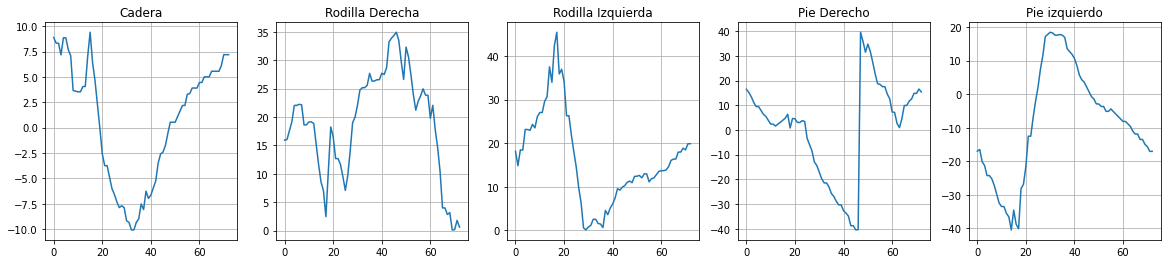

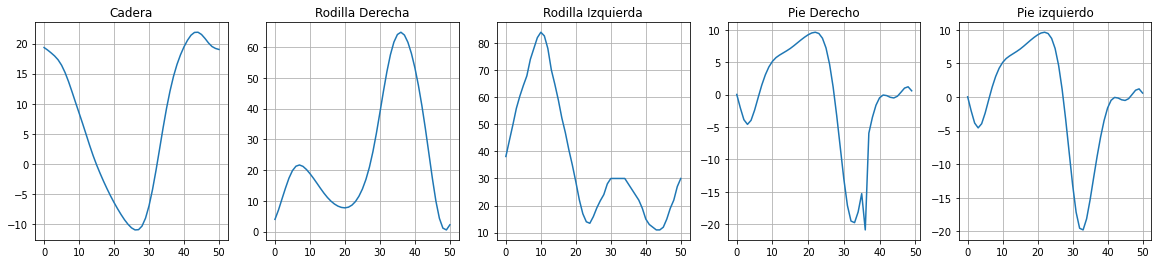

In [385]:
figure, ax = plt.subplots(1,5,figsize=(20,4))
ax[0].plot(np.array(np.array(angles_c2)*-1+10))
ax[0].set_title("Cadera")
ax[0].grid("on")
ax[1].plot(angles_r)
ax[1].set_title("Rodilla Derecha")
ax[1].grid("on")
ax[2].plot(angles_r2)
ax[2].set_title("Rodilla Izquierda")
ax[2].grid("on")
ax[3].plot(angles_t)
ax[3].set_title("Pie Derecho")
ax[3].grid("on")
ax[4].plot(angles_t2)
ax[4].set_title("Pie izquierdo")
ax[4].grid("on")

###### REAL DATA ####
plot_real_data_sagital()

# Junior Frontal

In [386]:
video_path =  'utils\\junior\\Junior_Frontal_Pierna derecha.mp4'
video_path2 =  'utils\\junior\\Junior_Frontal_pierna Izquierda.mp4'
th =120
angles_c,angles_r,angles_t,angles_c2,angles_r2,angles_t2 =  digital_goniomertry2(video_path,video_path2,th,scale_percent=90,version= "sticky",line="conitnues")

Right Hip ROM:  20.06 - 34.25
Right Knee ROM:  0.02 - 11.52
Right Ankle ROM:  0.0 - 8.97

Left Hip ROM:  16.49 - 33.12
Left Knee ROM:  0.09 - 11.8
Left Ankle ROM:  0.0 - 6.75

Center of mass x movement:  5.5 cm 


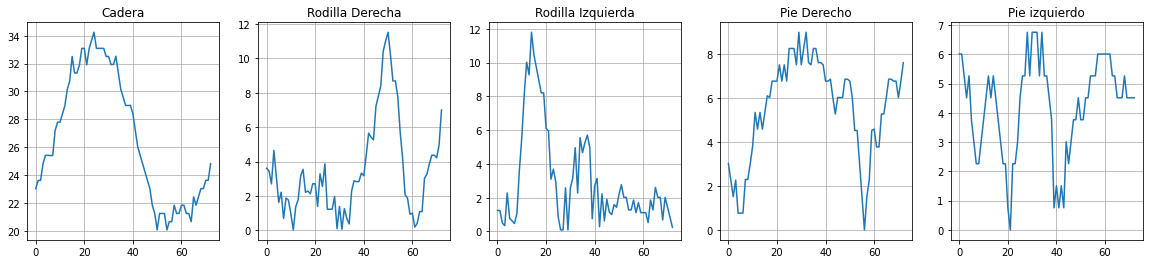

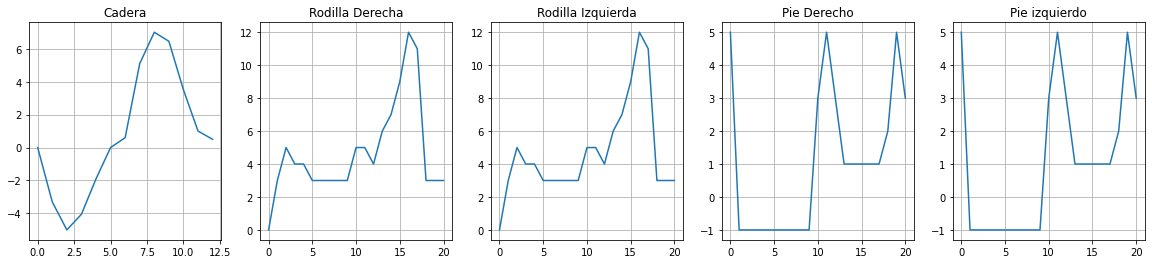

In [387]:
figure, ax = plt.subplots(1,5,figsize=(20,4))
ax[0].plot(np.array(angles_c))
ax[0].set_title("Cadera")
ax[0].grid("on")
ax[1].plot(angles_r)
ax[1].set_title("Rodilla Derecha")
ax[1].grid("on")
ax[2].plot(angles_r2)
ax[2].set_title("Rodilla Izquierda")
ax[2].grid("on")
ax[3].plot(angles_t)
ax[3].set_title("Pie Derecho")
ax[3].grid("on")
ax[4].plot(angles_t2)
ax[4].set_title("Pie izquierdo")
ax[4].grid("on")

###### REAL DATA ####
plot_real_data_frontal()

# Nora Sagital

In [388]:
video_path =  'utils\\nora\\Nora_PiernaDerecha_sagital_1.mp4' 
video_path2 =  'utils\\nora\\Nora_frontal_pierna_Izquierda_1.mp4'
th =120
angles_c,angles_r,angles_t,angles_c2,angles_r2,angles_t2 =  digital_goniomertry(video_path,video_path2,th,scale_percent=60,version= "sticky",line="conitnues")

Right Hip ROM:  -14.04 - 16.78
Right Knee ROM:  0.1 - 34.9
Right Ankle ROM:  -45.52 - 32.92

Left Hip ROM:  1.39 - 79.38
Left Knee ROM:  0.49 - 13.52
Left Ankle ROM:  -4.95 - 5.4

Center of mass x movement:  49.385416666666664 cm 


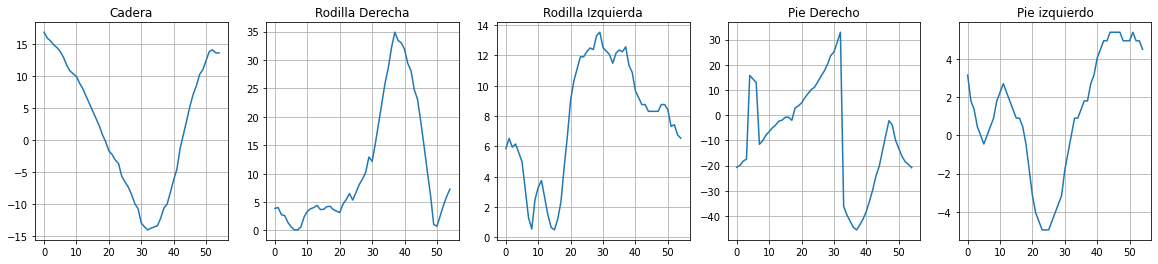

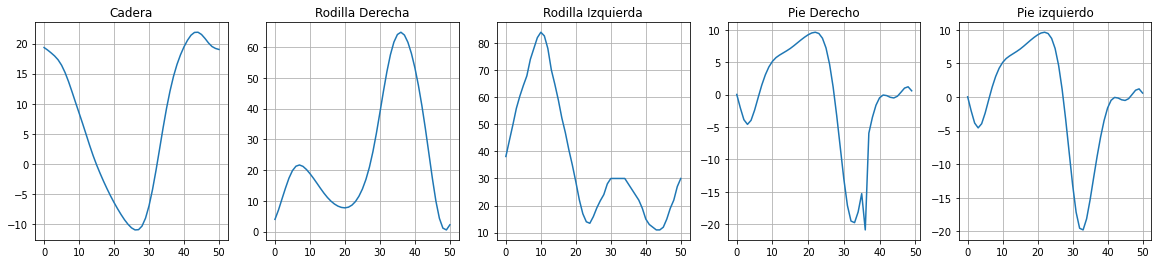

In [389]:
figure, ax = plt.subplots(1,5,figsize=(20,4))
ax[0].plot(np.array(angles_c))
ax[0].set_title("Cadera")
ax[0].grid("on")
ax[1].plot(angles_r)
ax[1].set_title("Rodilla Derecha")
ax[1].grid("on")
ax[2].plot(angles_r2)
ax[2].set_title("Rodilla Izquierda")
ax[2].grid("on")
ax[3].plot(angles_t)
ax[3].set_title("Pie Derecho")
ax[3].grid("on")
ax[4].plot(angles_t2)
ax[4].set_title("Pie izquierdo")
ax[4].grid("on")

###### REAL DATA ####
plot_real_data_sagital()

# Nora Frontal 

In [390]:
video_path =  'utils\\nora\\Nora_frontal_pierna_derecha_1.mp4'
video_path2 =  'utils\\nora\\Nora_frontal_pierna_Izquierda_1 (1).mp4'
th =120
angles_c,angles_r,angles_t,angles_c2,angles_r2,angles_t2 =  digital_goniomertry2(video_path,video_path2,th,scale_percent=60,version= "sticky",line="conitnues")

Right Hip ROM:  27.11 - 40.77
Right Knee ROM:  0.35 - 8.31
Right Ankle ROM:  0.36 - 9.64

Left Hip ROM:  26.21 - 41.62
Left Knee ROM:  0.49 - 13.52
Left Ankle ROM:  0.0 - 5.4

Center of mass x movement:  5.614583333333333 cm 


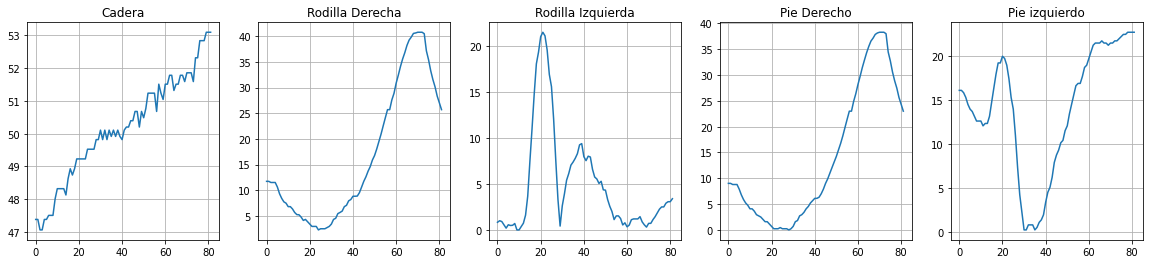

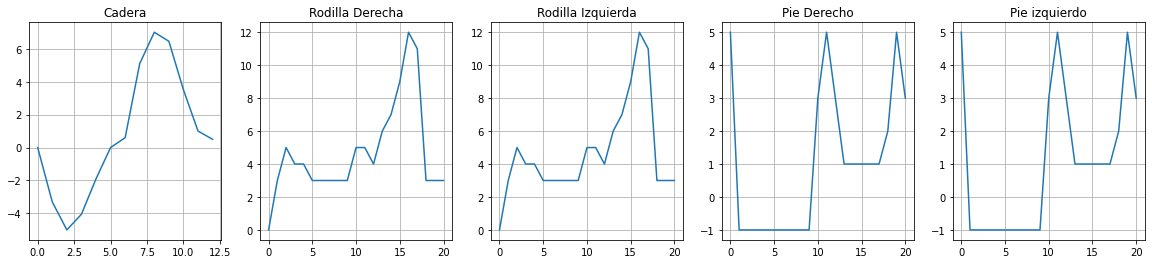

In [365]:
figure, ax = plt.subplots(1,5,figsize=(20,4))
ax[0].plot(np.array(angles_c))
ax[0].set_title("Cadera")
ax[0].grid("on")
ax[1].plot(angles_r)
ax[1].set_title("Rodilla Derecha")
ax[1].grid("on")
ax[2].plot(angles_r2)
ax[2].set_title("Rodilla Izquierda")
ax[2].grid("on")
ax[3].plot(angles_t)
ax[3].set_title("Pie Derecho")
ax[3].grid("on")
ax[4].plot(angles_t2)
ax[4].set_title("Pie izquierdo")
ax[4].grid("on")

plot_real_data_frontal()

# Victor Sagital 

In [391]:
video_path =  'utils\\victor\\Victor_Sagital_pierna derecha.mp4'
video_path2 =  'utils\\victor\\Victor_Sagital_pierna izquierda.mp4'
th =120
angles_c,angles_r,angles_t,angles_c2,angles_r2,angles_t2 =  digital_goniomertry(video_path,video_path2,th,scale_percent=50,version= "sticky",line="conitnues")

c:\users\eduardo\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arccos
  """


Right Hip ROM:  -14.55 - 13.15
Right Knee ROM:  0.02 - 43.26
Right Ankle ROM:  -43.71 - 22.97

Left Hip ROM:  nan - nan
Left Knee ROM:  7.94 - 48.13
Left Ankle ROM:  -14.04 - 43.51

Center of mass x movement:  50.943749999999994 cm 


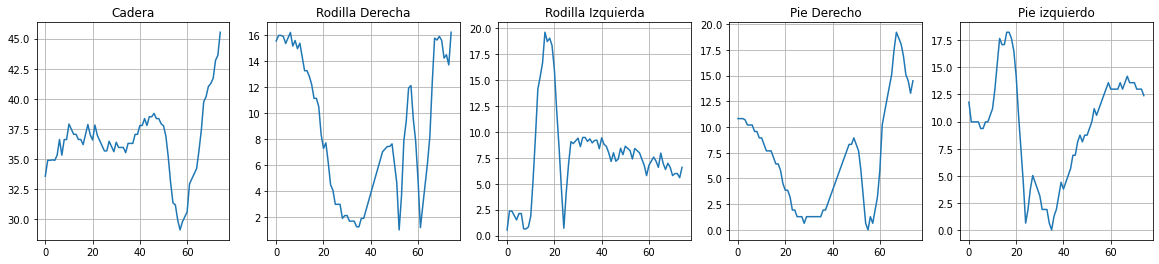

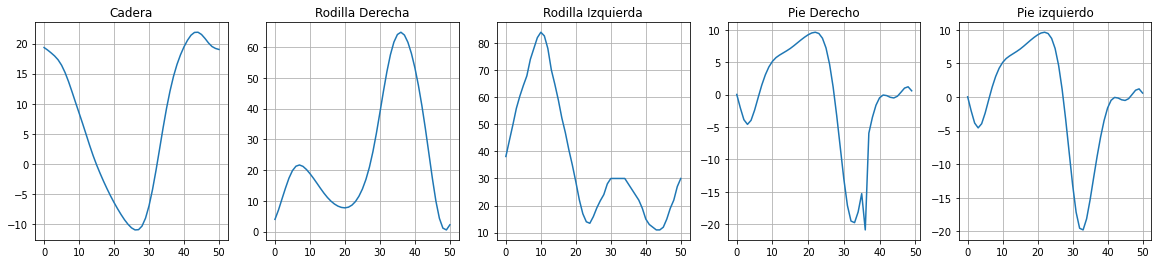

In [394]:
figure, ax = plt.subplots(1,5,figsize=(20,4))
ax[0].plot(np.array(angles_c))
ax[0].set_title("Cadera")
ax[0].grid("on")
ax[1].plot(angles_r)
ax[1].set_title("Rodilla Derecha")
ax[1].grid("on")
ax[2].plot(angles_r2)
ax[2].set_title("Rodilla Izquierda")
ax[2].grid("on")
ax[3].plot(angles_t)
ax[3].set_title("Pie Derecho")
ax[3].grid("on")
ax[4].plot(angles_t2)
ax[4].set_title("Pie izquierdo")
ax[4].grid("on")

###### REAL DATA ####
plot_real_data_sagital()

# Victor Frontal 

In [392]:
video_path =  'utils\\victor\\Victor_Frontal_piernaderecha_1.mp4'
video_path2 =  'utils\\victor\\Victor_Frontal_piernaizquierda_1.mp4'
th =120
angles_c,angles_r,angles_t,angles_c2,angles_r2,angles_t2 =  digital_goniomertry2(video_path,video_path2,th,scale_percent=50,version= "sticky",line="conitnues")

Right Hip ROM:  29.13 - 45.53
Right Knee ROM:  1.05 - 16.21
Right Ankle ROM:  0.0 - 19.2

Left Hip ROM:  28.98 - 61.51
Left Knee ROM:  0.55 - 19.59
Left Ankle ROM:  0.0 - 18.25

Center of mass x movement:  7.21875 cm 


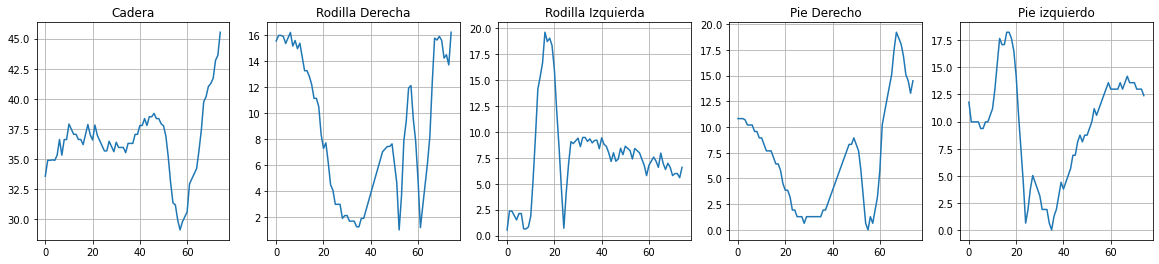

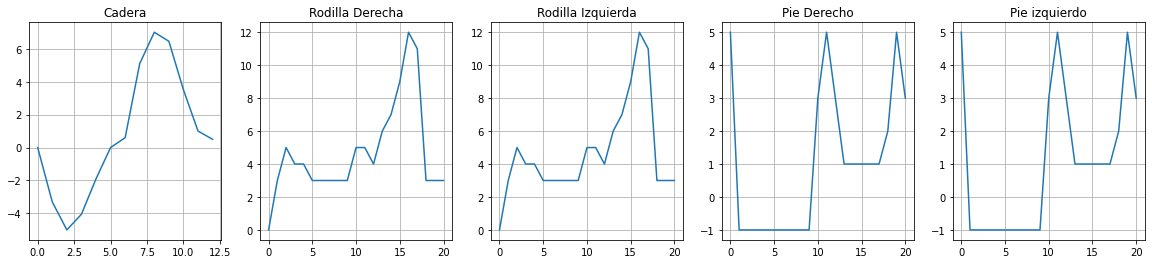

In [393]:
figure, ax = plt.subplots(1,5,figsize=(20,4))
ax[0].plot(np.array(angles_c))
ax[0].set_title("Cadera")
ax[0].grid("on")
ax[1].plot(angles_r)
ax[1].set_title("Rodilla Derecha")
ax[1].grid("on")
ax[2].plot(angles_r2)
ax[2].set_title("Rodilla Izquierda")
ax[2].grid("on")
ax[3].plot(angles_t)
ax[3].set_title("Pie Derecho")
ax[3].grid("on")
ax[4].plot(angles_t2)
ax[4].set_title("Pie izquierdo")
ax[4].grid("on")

plot_real_data_frontal()